In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
hood = yf.Ticker("HOOD")
google = yf.Ticker("GOOG")
spy = yf.Ticker("SPY")

In [3]:
spy_hist = spy.history(period="max").reset_index()
spy_hist['return'] = spy_hist.eval('(Close-Open)/Open*100')
spy_hist['year'] = spy_hist['Date'].dt.year

<AxesSubplot:ylabel='Frequency'>

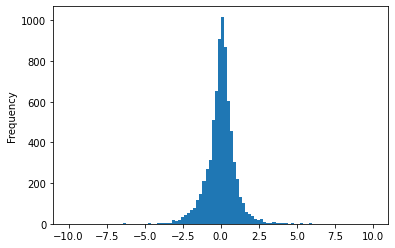

In [4]:
spy_hist['return'].plot.hist(range=(-10,10), bins=100)

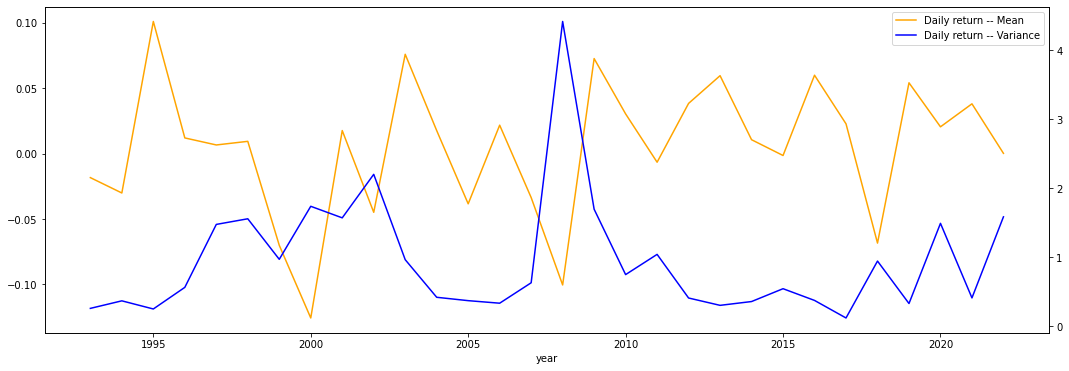

In [5]:
fig, ax1 = plt.subplots(figsize=(18,6))

spy_hist.groupby('year').agg({'return':'mean'}).plot(c='orange', ax=ax1)
ax2 = ax1.twinx()
spy_hist.groupby('year').agg({'return':'var'}).plot(ax=ax2, c='blue')
ax1.plot(np.nan, '-r', c='blue')  # Make an agent in ax
ax1.legend(['Daily return -- Mean', 'Daily return -- Variance'], loc=0)
ax2.get_legend().remove()

# Beta

In [6]:
def compute_beta(ticker, plot = True, date_range = None):
    stock = yf.Ticker(ticker)
    stock_hist = stock.history(period="max").reset_index()
    spy = yf.Ticker("SPY")
    spy_hist = spy.history(period="max").reset_index()
    stock_hist['return'] = stock_hist.eval('100*(Close-Open)/Open')
    spy_hist['return'] = spy_hist.eval('(Close-Open)/Open*100')
    
    merged_df = stock_hist[['Date','return']].merge(spy_hist[['Date','return']], on='Date', how='inner').rename(columns={'return_x':'return_stock', 'return_y':'return_spy'})
    if date_range:
        merged_df = merged_df[(merged_df['Date'] >= pd.to_datetime(date_range[0])) & (merged_df['Date'] <= pd.to_datetime(date_range[1]))].reset_index(drop=True)
    
    X = np.array(merged_df['return_spy']).reshape(-1, 1)
    y = np.array(merged_df['return_stock']).reshape(-1, 1)
    reg = LinearRegression().fit(X, y)
    if plot:
        fig, ax = plt.subplots(figsize=(12,12))
        xlist = np.linspace(-10,10,21)
        ylist = reg.intercept_[0] + reg.coef_[0][0]*xlist
        merged_df.plot.scatter(x='return_spy', y='return_stock', ax=ax)
        ax.plot(xlist, ylist, c='orange',label=f'{round(reg.coef_[0][0],2)}x+{round(reg.intercept_[0],2)}')
        lim = max(np.percentile(y, 98), np.percentile(X, 98))
        ax.set_xlim((-lim,lim))
        ax.set_ylim((-lim,lim))
        ax.legend()
    
    return reg, merged_df

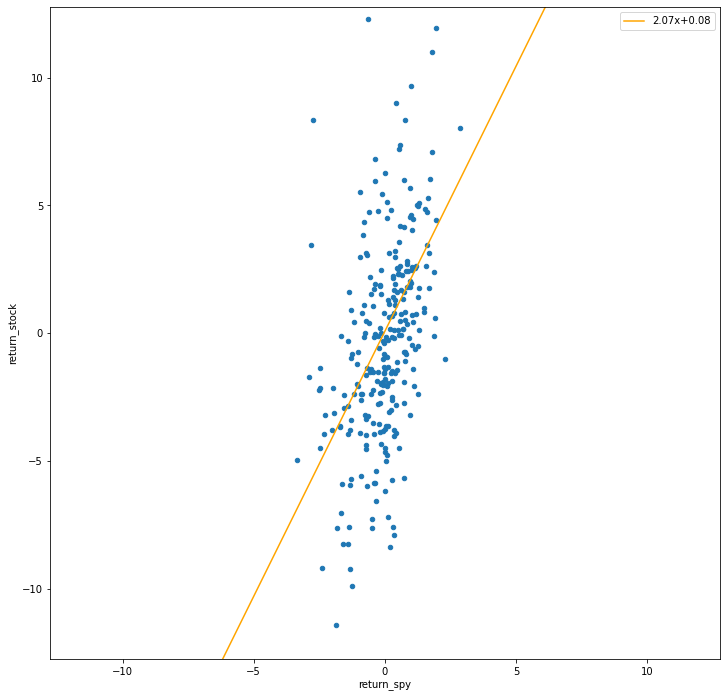

In [7]:
reg, df = compute_beta("HOOD",True, ['2018-01-01','2023-01-01'])

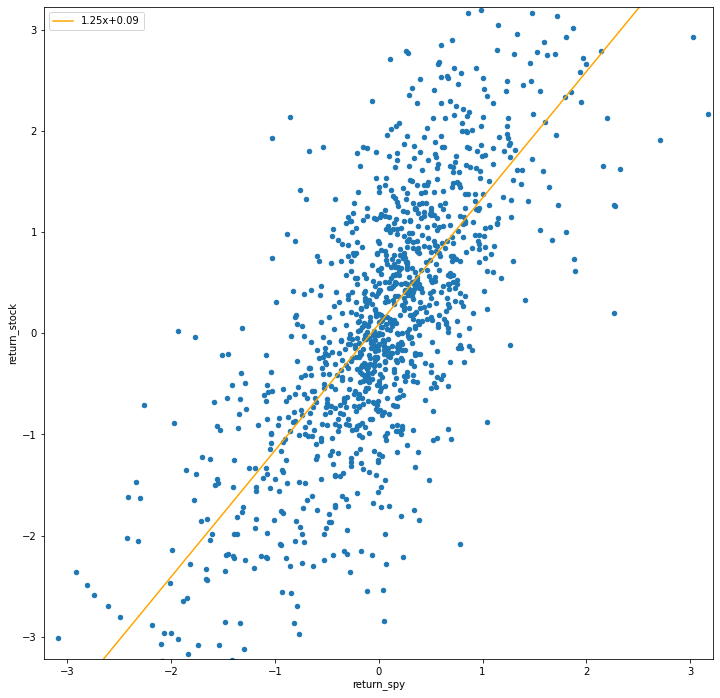

In [8]:
reg, df = compute_beta("AAPL",True, ['2018-01-01','2023-01-01'])

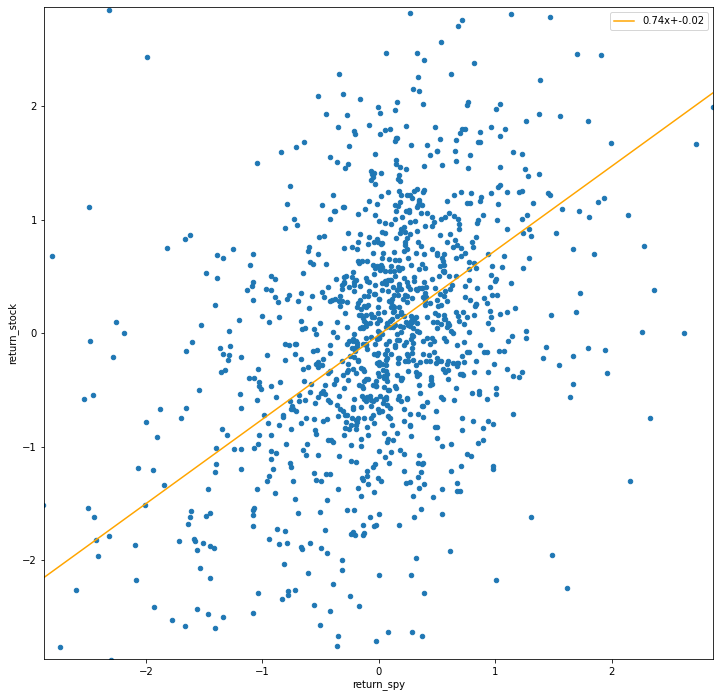

In [9]:
reg, df = compute_beta("LMT", True, ['2018-01-01','2023-01-01'])

In [10]:
ticker = 'AAPL'
years = range(2006, 2023)
betas = []
for y in years:
    date_range = [f'{y}-01-01', f'{y}-12-31']
    reg, df = compute_beta(ticker, plot = False, date_range = date_range)
    betas.append(reg.coef_[0][0])

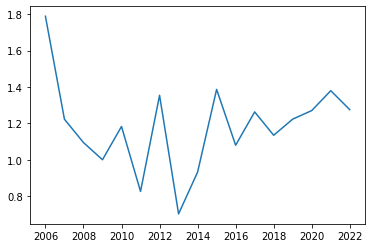

In [11]:
plt.plot(years, betas)

In [14]:
apple = yf.Ticker("AAPL")
print(apple.info['beta'])

1.230174


# Find stocks with low beta and high dividend

In [79]:
from yahoo_fin import stock_info as si
tickers = si.tickers_sp500()
from tqdm import tqdm

In [84]:
l = []
for i in tqdm(range(len(tickers))):
    res = {}
    t = tickers[i]
    tt = yf.Ticker(t)
    tt_hist = tt.history(period="6y").reset_index()
    mask = ((tt_hist['Date'].dt.year==2022) & (tt_hist['Dividends']>0))
    res['dividends'] = 0
    res['ticker'] = t
    
    if sum(mask)>0:
        info = tt_hist[mask].tail(1).reset_index(drop=True)
        res['dividends'] = info.loc[0,'Dividends']/info.loc[0,'Close']
    
    reg, _ = compute_beta(t, False, ['2018-01-01','2023-01-01'])
    res['beta'] = reg.coef_[0][0]
        
    l.append(res)

100%|██████████| 503/503 [11:31<00:00,  1.38s/it]


In [85]:
df = pd.DataFrame.from_dict(l)

<AxesSubplot:xlabel='dividends', ylabel='beta'>

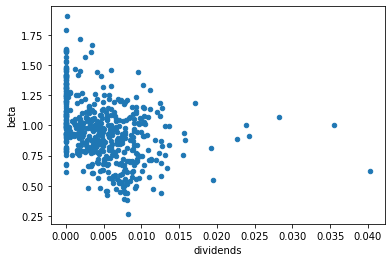

In [87]:
df.plot.scatter(x='dividends',y='beta')

In [98]:
stock = yf.Ticker('mo')
stock_hist = psa.history(period="6y").reset_index()

In [99]:
stock_hist[stock_hist['Dividends']>0]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
5,2016-09-13,44.838286,45.026832,44.321540,44.377403,6437700,0.61,0
74,2016-12-20,47.317288,47.451168,46.739475,47.451168,6976500,0.61,0
129,2017-03-13,53.941558,54.126237,53.550881,53.735565,6836200,0.61,0
193,2017-06-13,53.507863,53.701211,53.328835,53.672565,5196500,0.61,0
258,2017-09-14,44.959551,45.176677,44.764138,45.075352,7552400,0.66,0
326,2017-12-20,53.463447,53.492659,52.061320,53.017979,7400700,0.66,0
382,2018-03-14,48.492386,48.640007,46.949784,47.104782,7939600,0.70,0
446,2018-06-14,42.440704,42.545311,42.141828,42.365986,5602500,0.70,0
509,2018-09-13,47.228127,47.281099,45.888698,46.509224,8938300,0.80,0
579,2018-12-24,36.740637,37.125275,36.540627,36.586784,9548700,0.80,0


In [96]:
df.sort_values('dividends', ascending=False).head(10)

,dividends,ticker,beta
380,0.040287,PSA,0.624745
385,0.035448,PXD,1.000639
431,0.028223,TDG,1.069440
280,0.024295,LUMN,0.911581
177,0.023841,FANG,1.002421
119,0.022680,CTRA,0.890509
306,0.019443,MO,0.550506
469,0.019161,VNO,0.810380
147,0.017148,DVN,1.186665
417,0.015760,SPG,0.876534


In [41]:
lmt = yf.Ticker("LMT")
lmt_hist = lmt.history(period="max").reset_index()


In [69]:
lmt_hist[].tail(1).reset_index(drop=True).loc[0,'Dividends']

2.8